In [46]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [47]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2,InceptionV3
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2, InceptionV3
from tensorflow.keras import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity

import PIL
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.utils import np_utils



In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [50]:
image_paths = ['Data/train/normal',
               'Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
               'Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
               'Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [51]:
def show_images(path, num_images, num_rows, num_cols):
    count = 0
    sizes = []
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for filename in os.listdir(path):
        if count < num_images and (filename.endswith(".jpg") or filename.endswith(".png")):
            img = Image.open(os.path.join(path, filename))
            img = img.convert('RGB')

            size = img.size
            sizes.append(size)

            row = count // num_cols
            col = count % num_cols
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            count += 1
        elif count >= num_images:
            break

    avg_size = np.array(sizes).mean(axis=0)
    avg_size = np.ceil(avg_size / 32) * 32
    print("Average image size: ", avg_size)

    plt.show()

Average image size:  [416. 288.]


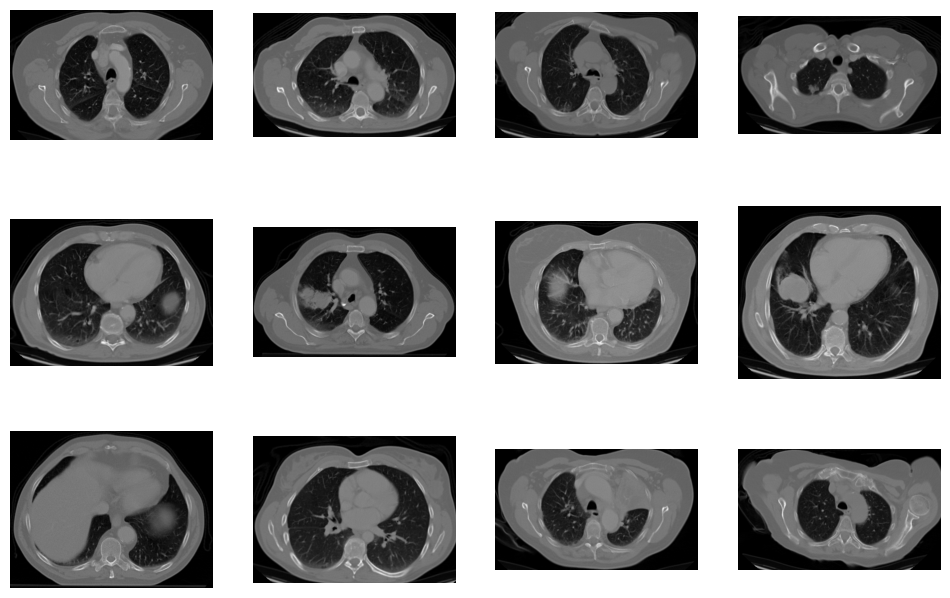

In [52]:
show_images("Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib", 12, 3, 4)

#### Base models

In [53]:
train_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, brightness_range=[0.4, 1.2], shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

valid_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(dtype='float32', rescale = 1./255)

In [54]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (384,384), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (384,384), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (384,384), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [55]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 384, 384, 8)       224       
                                                                 
 conv2d_7 (Conv2D)           (None, 384, 384, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 192, 192, 16)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 192, 192, 16)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 192, 192, 64)      9280      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 96, 96, 64)       0         
 2D)                                                  

In [56]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset, callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.9323 - tp: 94.0000 - fp: 161.0000 - tn: 1678.0000 - fn: 519.0000 - accuracy: 0.7227 - precision: 0.3686 - recall: 0.1533 - auc: 0.5658 - sensitivity: 0.2507
Epoch 1: val_loss improved from inf to 1.33394, saving model to model.hdf5
20/20 [==============================] - 39s 2s/step - loss: 2.9323 - tp: 94.0000 - fp: 161.0000 - tn: 1678.0000 - fn: 519.0000 - accuracy: 0.7227 - precision: 0.3686 - recall: 0.1533 - auc: 0.5658 - sensitivity: 0.2507 - val_loss: 1.3339 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 70.0000 - val_accuracy: 0.7569 - val_precision: 1.0000 - val_recall: 0.0278 - val_auc: 0.5265 - val_sensitivity: 0.2361
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.3074 - tp: 54.0000 - fp: 15.0000 - tn: 1824.0000 - fn: 559.0000 - accuracy: 0.7659 - precision: 0.7826 - recall: 0.0881 - auc: 0.6599 - sensitivity: 0.3660
Epoch 2: val_loss did not improve from 1.333

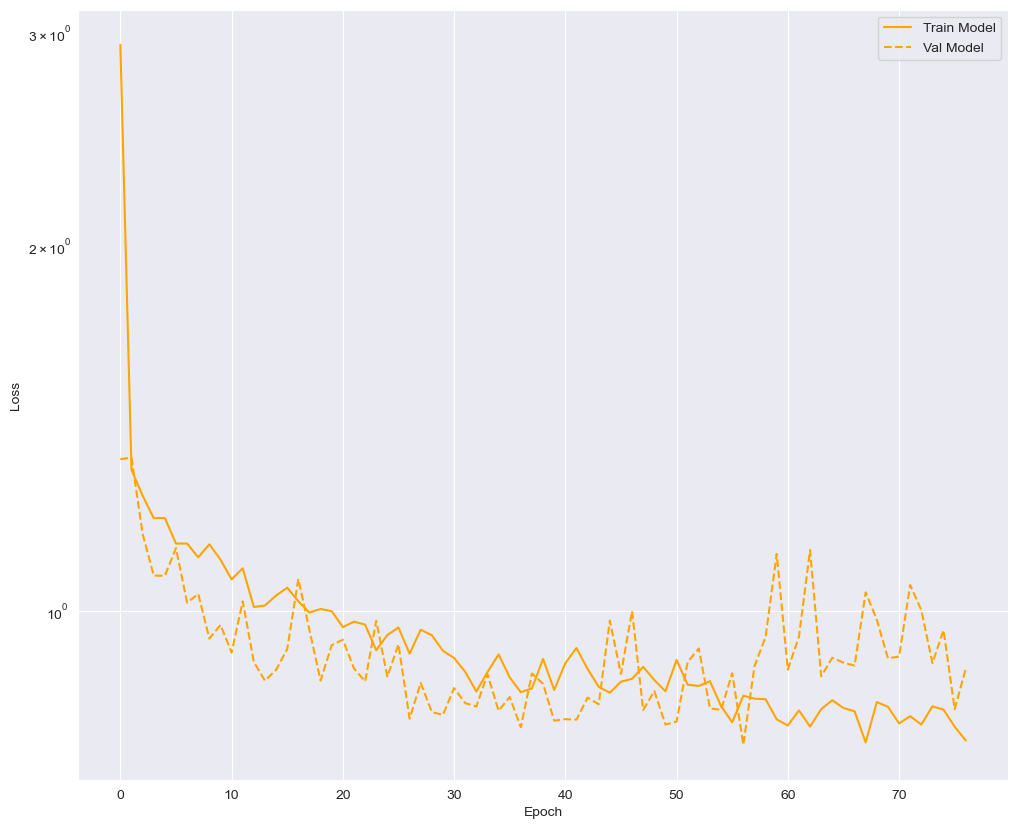

In [57]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
                 label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
                 label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [58]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 106ms/step - loss: 1.0532 - tp: 124.0000 - fp: 58.0000 - tn: 887.0000 - fn: 191.0000 - accuracy: 0.8024 - precision: 0.6813 - recall: 0.3937 - auc: 0.8071 - sensitivity: 0.5735


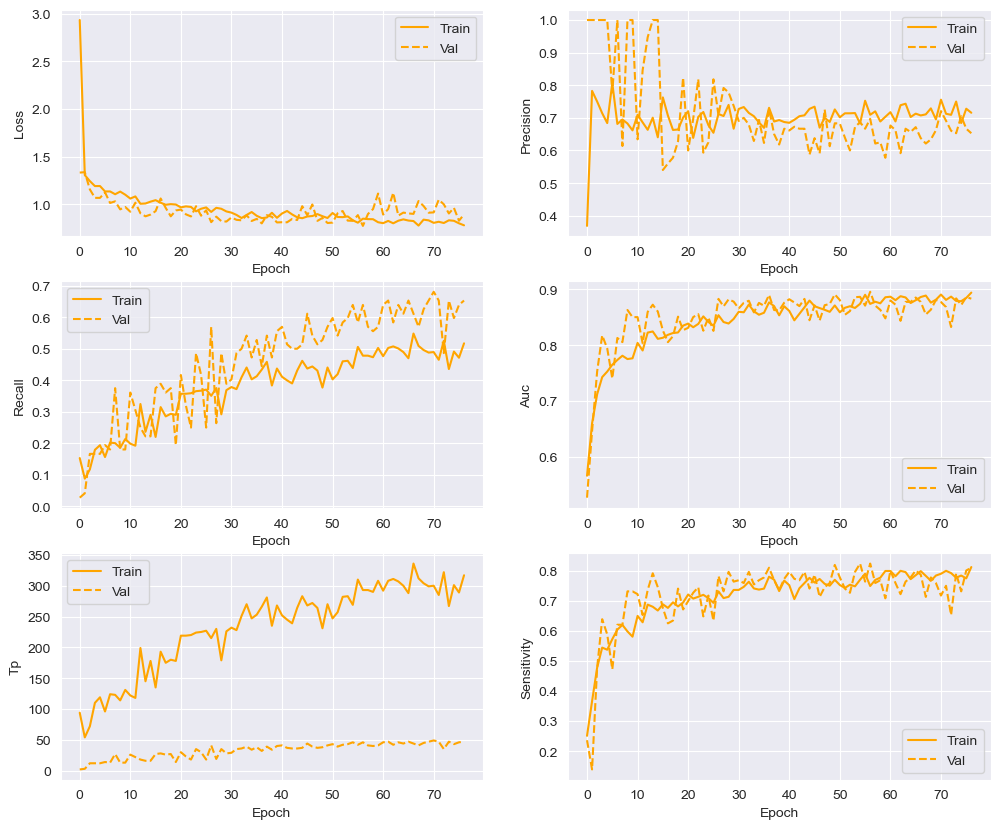

In [59]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [60]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384, 384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
#model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 384, 384, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 192, 192, 8)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 192, 192, 32)      2336      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 96, 96, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 294912)           

In [61]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset, callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 8.9169 - tp: 138.0000 - fp: 339.0000 - tn: 1500.0000 - fn: 475.0000 - accuracy: 0.6680 - precision: 0.2893 - recall: 0.2251 - auc: 0.5200 - sensitivity: 0.0076
Epoch 1: val_loss improved from inf to 1.68919, saving model to model.hdf5
20/20 [==============================] - 28s 1s/step - loss: 8.9169 - tp: 138.0000 - fp: 339.0000 - tn: 1500.0000 - fn: 475.0000 - accuracy: 0.6680 - precision: 0.2893 - recall: 0.2251 - auc: 0.5200 - sensitivity: 0.0076 - val_loss: 1.6892 - val_tp: 9.0000 - val_fp: 19.0000 - val_tn: 197.0000 - val_fn: 63.0000 - val_accuracy: 0.7153 - val_precision: 0.3214 - val_recall: 0.1250 - val_auc: 0.4969 - val_sensitivity: 0.1898
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.3443 - tp: 50.0000 - fp: 23.0000 - tn: 1816.0000 - fn: 563.0000 - accuracy: 0.7610 - precision: 0.6849 - recall: 0.0816 - auc: 0.6115 - sensitivity: 0.3083
Epoch 2: val_loss improved from 1.68919 to 1.

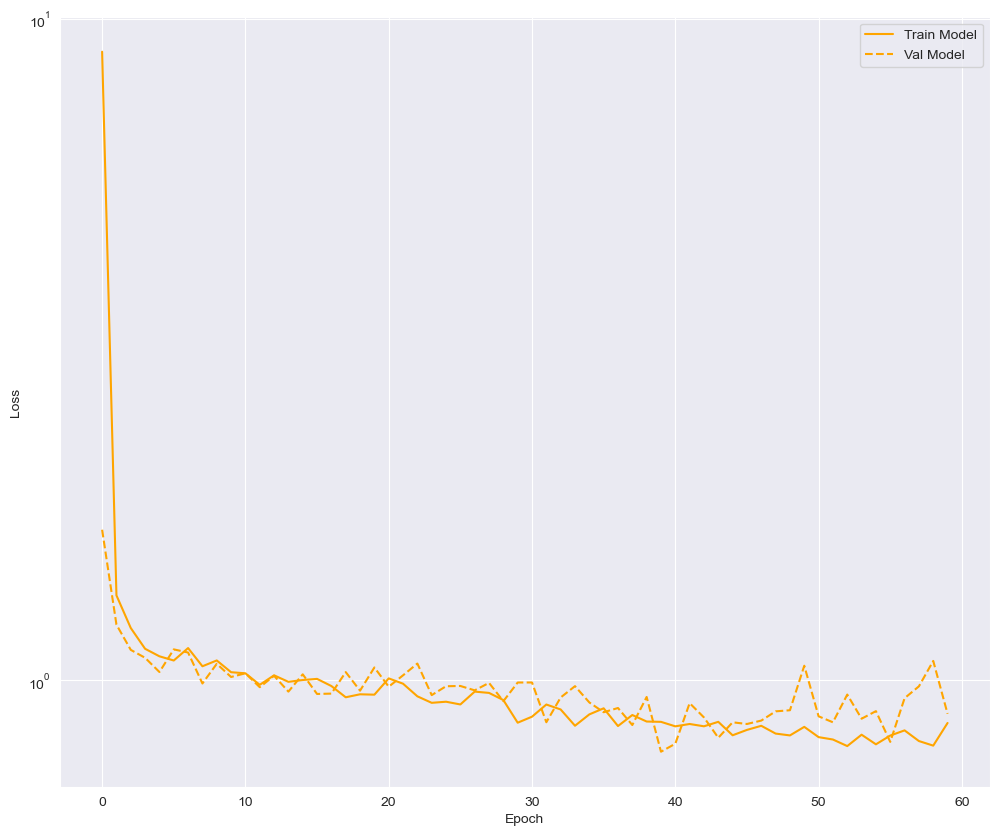

In [62]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [63]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 100ms/step - loss: 0.8337 - tp: 142.0000 - fp: 74.0000 - tn: 871.0000 - fn: 173.0000 - accuracy: 0.8040 - precision: 0.6574 - recall: 0.4508 - auc: 0.8645 - sensitivity: 0.7302


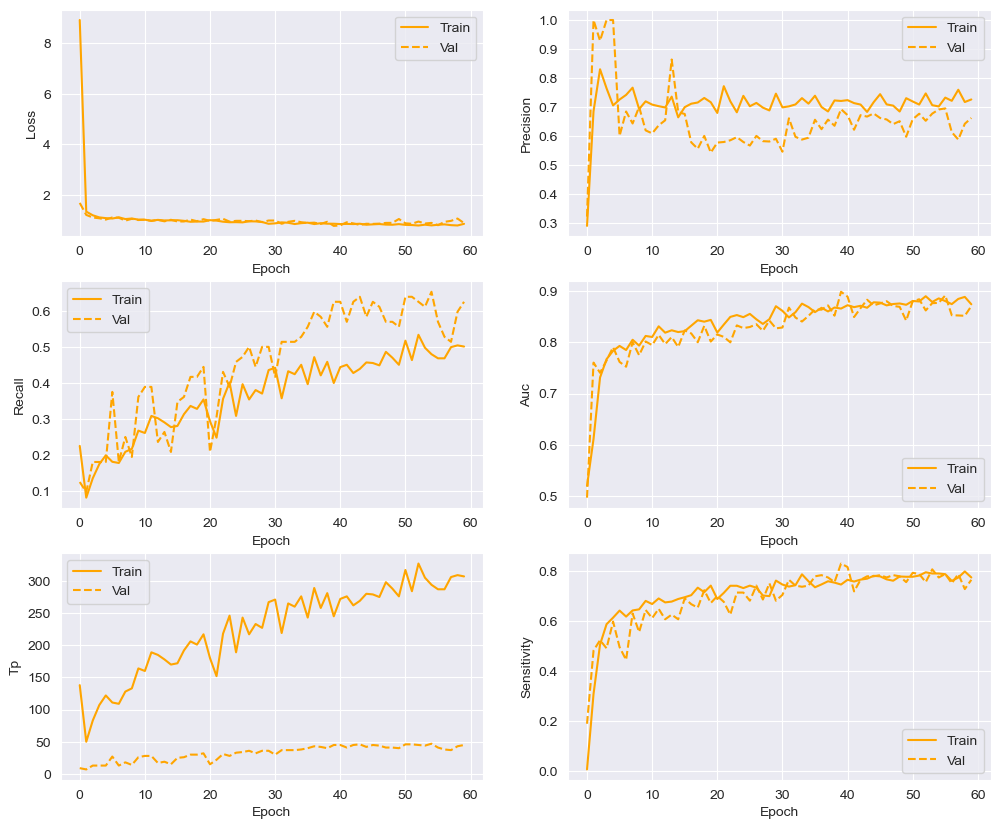

In [64]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [65]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, kernel_regularizer = regularizers.l2(1e-3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 384, 384, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 384, 384, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 384, 384, 8)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 192, 192, 8)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 192, 192, 32)      2336      
                                                                 
 batch_normalization_1 (Batc  (None, 192, 192, 32)    

In [66]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset, callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 76.4255 - tp: 233.0000 - fp: 370.0000 - tn: 1469.0000 - fn: 380.0000 - accuracy: 0.6941 - precision: 0.3864 - recall: 0.3801 - auc: 0.6016 - sensitivity: 0.0000e+00
Epoch 1: val_loss improved from inf to 6.23659, saving model to model.hdf5
20/20 [==============================] - 33s 2s/step - loss: 76.4255 - tp: 233.0000 - fp: 370.0000 - tn: 1469.0000 - fn: 380.0000 - accuracy: 0.6941 - precision: 0.3864 - recall: 0.3801 - auc: 0.6016 - sensitivity: 0.0000e+00 - val_loss: 6.2366 - val_tp: 30.0000 - val_fp: 42.0000 - val_tn: 174.0000 - val_fn: 42.0000 - val_accuracy: 0.7083 - val_precision: 0.4167 - val_recall: 0.4167 - val_auc: 0.5779 - val_sensitivity: 0.0000e+00
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 15.5981 - tp: 202.0000 - fp: 261.0000 - tn: 1578.0000 - fn: 411.0000 - accuracy: 0.7259 - precision: 0.4363 - recall: 0.3295 - auc: 0.6350 - sensitivity: 0.1218
Epoch 2: val_loss improved 

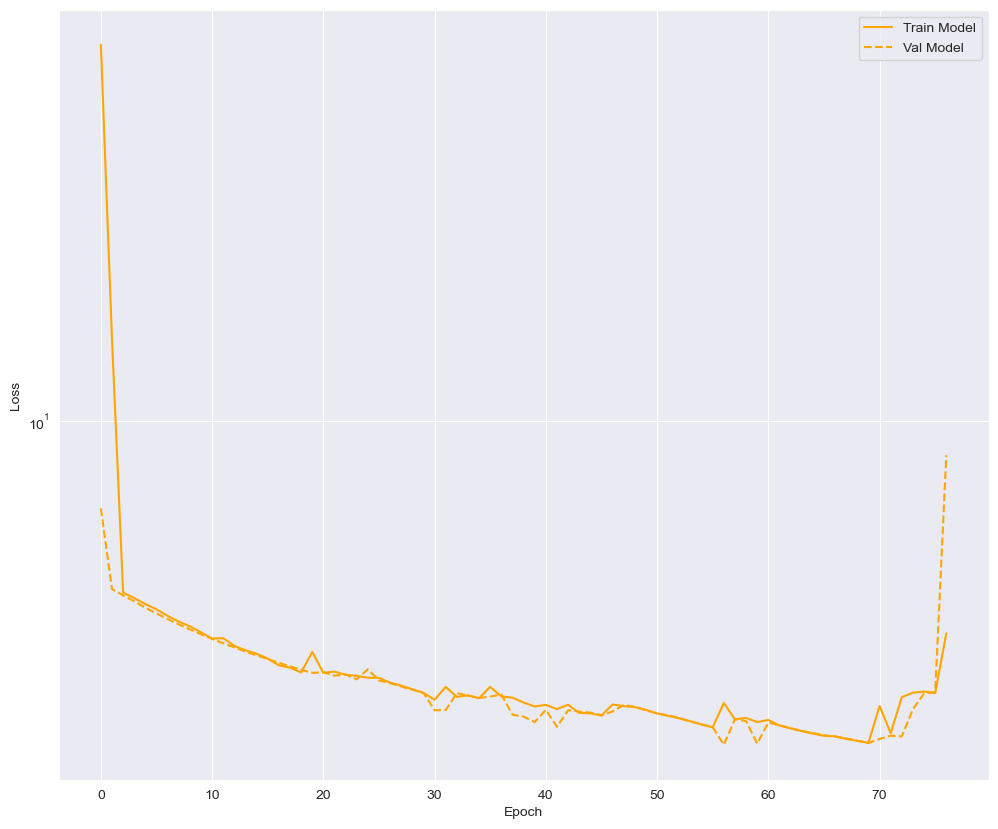

In [67]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [68]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 3s 130ms/step - loss: 5.9639 - tp: 45.0000 - fp: 231.0000 - tn: 714.0000 - fn: 270.0000 - accuracy: 0.6024 - precision: 0.1630 - recall: 0.1429 - auc: 0.4047 - sensitivity: 0.0000e+00


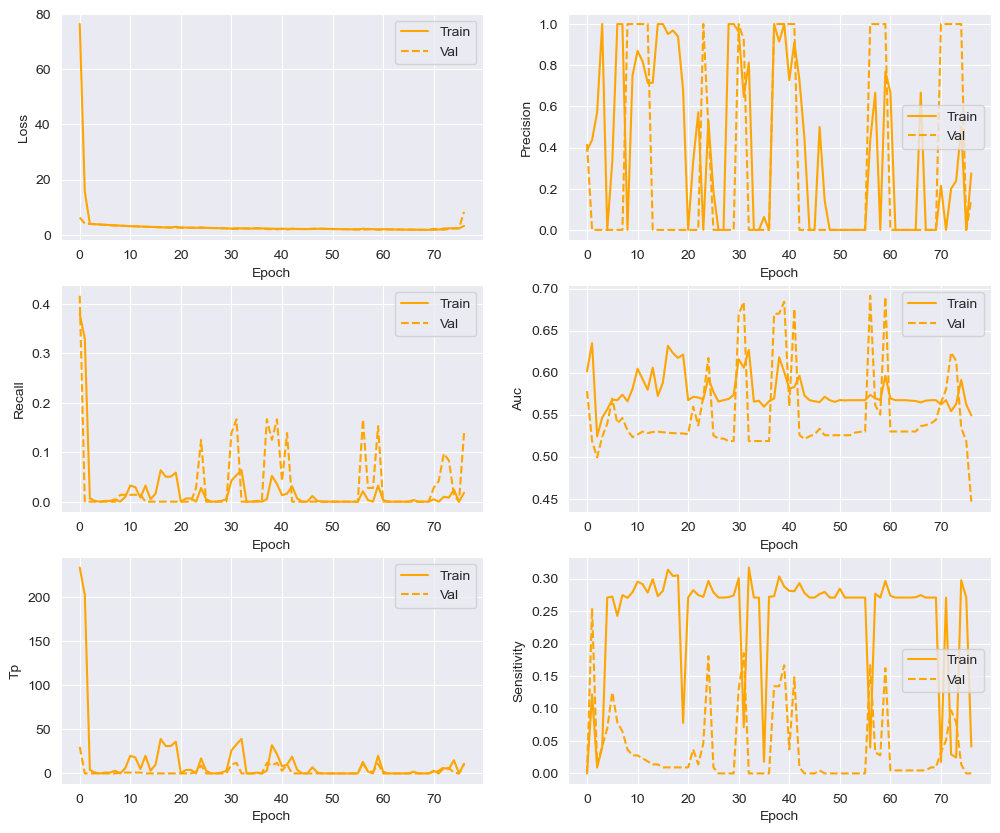

In [69]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [70]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dense(128, kernel_regularizer = regularizers.l2(1e-3)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 384, 384, 8)       224       
                                                                 
 batch_normalization_2 (Batc  (None, 384, 384, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 384, 384, 8)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 192, 192, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 192, 192, 16)      1168      
                                                                 
 batch_normalization_3 (Batc  (None, 192, 192, 16)    

In [71]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset, callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 41.8180 - tp: 194.0000 - fp: 412.0000 - tn: 1427.0000 - fn: 419.0000 - accuracy: 0.6611 - precision: 0.3201 - recall: 0.3165 - auc: 0.5563 - sensitivity: 0.2474
Epoch 1: val_loss improved from inf to 2.42048, saving model to model.hdf5
20/20 [==============================] - 29s 1s/step - loss: 41.8180 - tp: 194.0000 - fp: 412.0000 - tn: 1427.0000 - fn: 419.0000 - accuracy: 0.6611 - precision: 0.3201 - recall: 0.3165 - auc: 0.5563 - sensitivity: 0.2474 - val_loss: 2.4205 - val_tp: 29.0000 - val_fp: 42.0000 - val_tn: 174.0000 - val_fn: 43.0000 - val_accuracy: 0.7049 - val_precision: 0.4085 - val_recall: 0.4028 - val_auc: 0.5934 - val_sensitivity: 0.2685
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.9459 - tp: 101.0000 - fp: 152.0000 - tn: 1687.0000 - fn: 512.0000 - accuracy: 0.7292 - precision: 0.3992 - recall: 0.1648 - auc: 0.5966 - sensitivity: 0.3121
Epoch 2: val_loss improved from 2.42048 

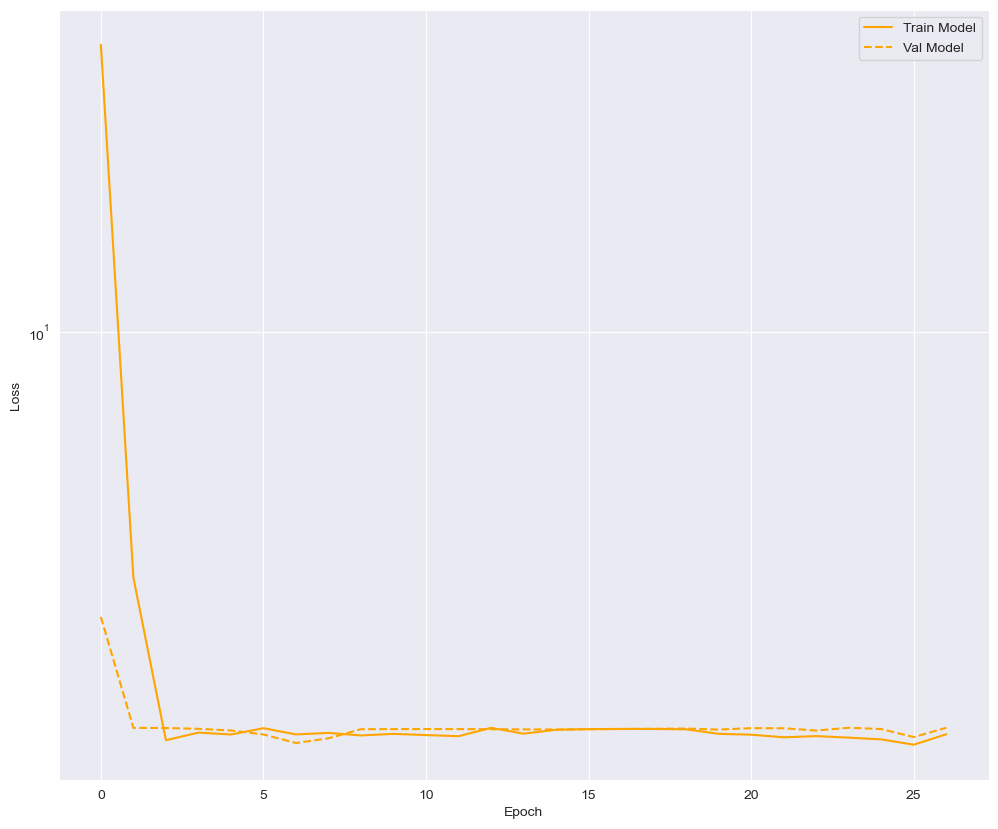

In [72]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [73]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 2s 96ms/step - loss: 1.3571 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 945.0000 - fn: 315.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6286 - sensitivity: 0.2794


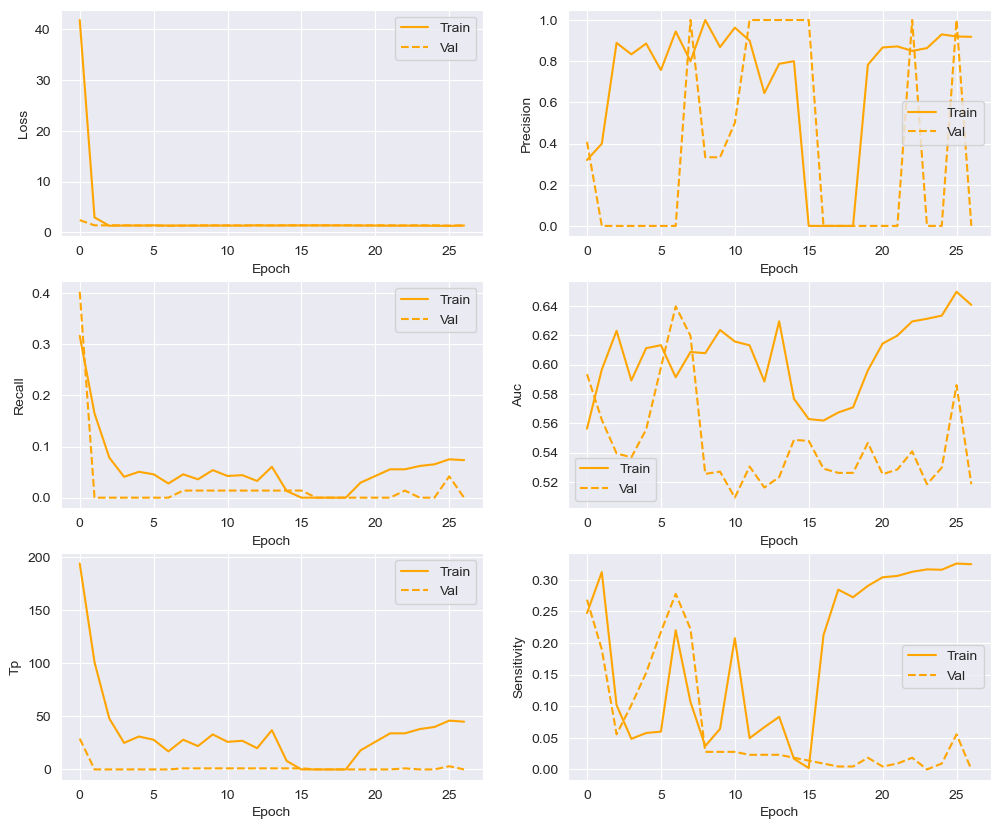

In [74]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [75]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), input_shape=(384,384,3), padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dense(128, kernel_regularizer = regularizers.l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 384, 384, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 384, 384, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 384, 384, 8)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 192, 192, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 192, 192, 32)      2336      
                                                                 
 batch_normalization_5 (Batc  (None, 192, 192, 32)    

In [76]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset, callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 36.1648 - tp: 205.0000 - fp: 377.0000 - tn: 1462.0000 - fn: 408.0000 - accuracy: 0.6799 - precision: 0.3522 - recall: 0.3344 - auc: 0.5879 - sensitivity: 0.2621
Epoch 1: val_loss improved from inf to 1.52256, saving model to model.hdf5
20/20 [==============================] - 24s 1s/step - loss: 36.1648 - tp: 205.0000 - fp: 377.0000 - tn: 1462.0000 - fn: 408.0000 - accuracy: 0.6799 - precision: 0.3522 - recall: 0.3344 - auc: 0.5879 - sensitivity: 0.2621 - val_loss: 1.5226 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5880 - val_sensitivity: 0.3519
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.5487 - tp: 34.0000 - fp: 20.0000 - tn: 1819.0000 - fn: 579.0000 - accuracy: 0.7557 - precision: 0.6296 - recall: 0.0555 - auc: 0.5964 - sensitivity: 0.0870
Epoch 2: val_loss did not im

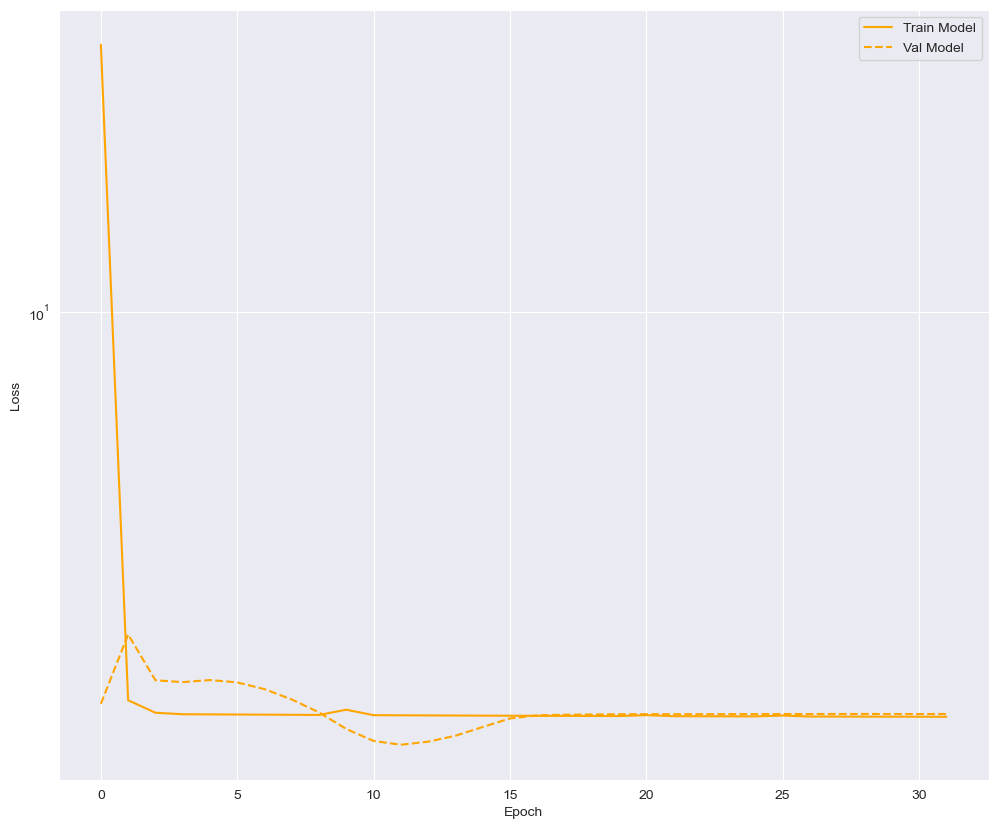

In [77]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [78]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 3s 139ms/step - loss: 1.4103 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 945.0000 - fn: 315.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6286 - sensitivity: 0.2794


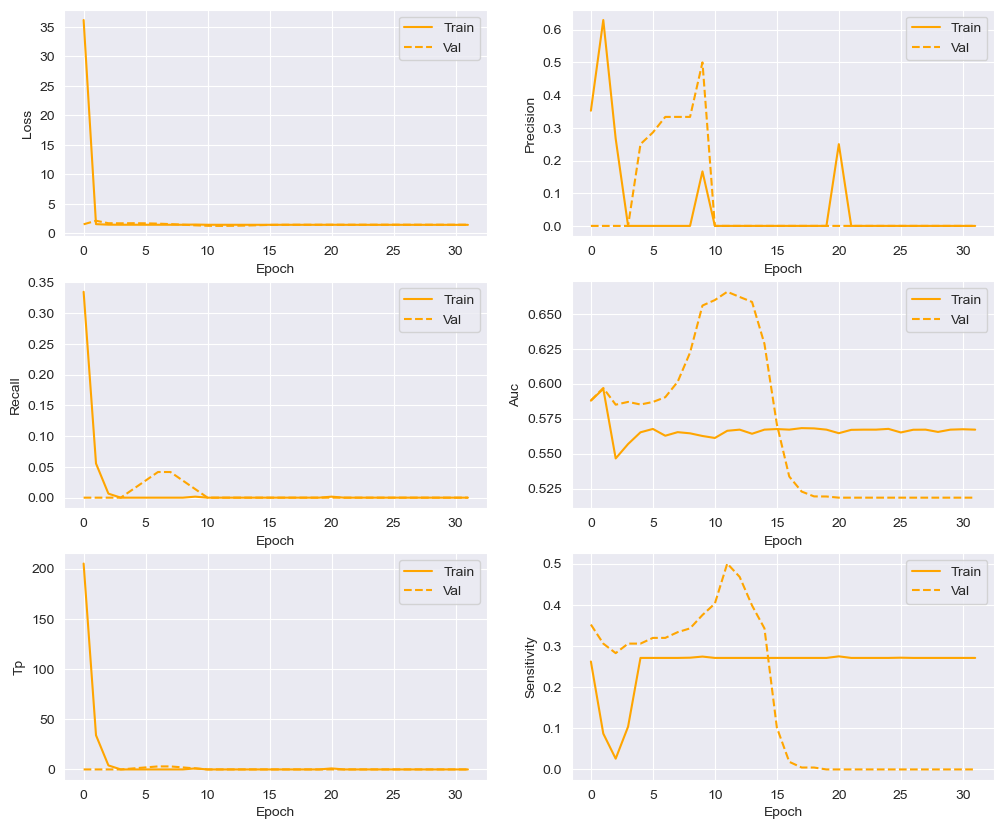

In [79]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()

In [80]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), input_shape=(384, 384,3), padding='same', activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
#model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 384, 384, 16)      1216      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 192, 192, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 192, 192, 64)      9280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 96, 96, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 96, 96, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 589824)           

In [81]:
checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset, callbacks = [checkpoint, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 7.6239 - tp: 105.0000 - fp: 237.0000 - tn: 1602.0000 - fn: 508.0000 - accuracy: 0.6962 - precision: 0.3070 - recall: 0.1713 - auc: 0.5420 - sensitivity: 0.0212
Epoch 1: val_loss improved from inf to 1.39399, saving model to model.hdf5
20/20 [==============================] - 47s 2s/step - loss: 7.6239 - tp: 105.0000 - fp: 237.0000 - tn: 1602.0000 - fn: 508.0000 - accuracy: 0.6962 - precision: 0.3070 - recall: 0.1713 - auc: 0.5420 - sensitivity: 0.0212 - val_loss: 1.3940 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5358 - val_sensitivity: 0.1157
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.3315 - tp: 34.0000 - fp: 19.0000 - tn: 1820.0000 - fn: 579.0000 - accuracy: 0.7561 - precision: 0.6415 - recall: 0.0555 - auc: 0.6447 - sensitivity: 0.3872
Epoch 2: val_loss improved fro

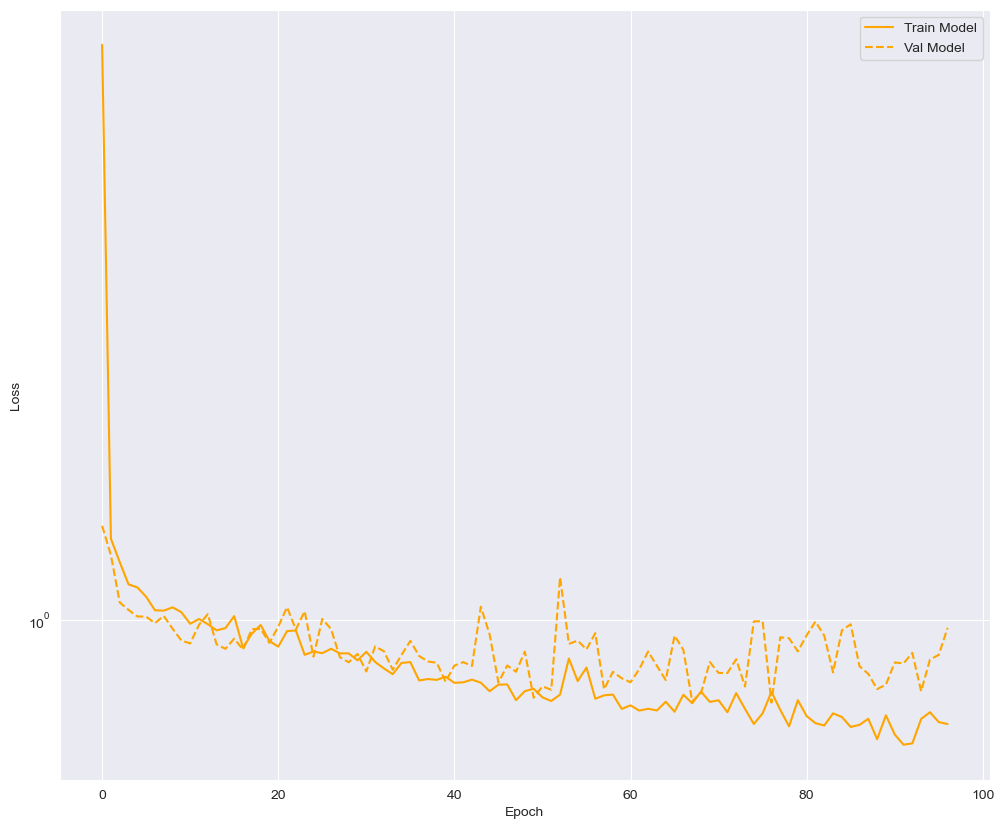

In [82]:
plt.semilogy(history.epoch,  history.history['loss'], color='orange',
             label='Train Model')
plt.semilogy(history.epoch,  history.history['val_loss'], color='orange',
             label='Val Model', linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [83]:
result = model.evaluate(test_dataset)

20/20 [==============================] - 3s 134ms/step - loss: 1.0499 - tp: 158.0000 - fp: 103.0000 - tn: 842.0000 - fn: 157.0000 - accuracy: 0.7937 - precision: 0.6054 - recall: 0.5016 - auc: 0.8393 - sensitivity: 0.7037


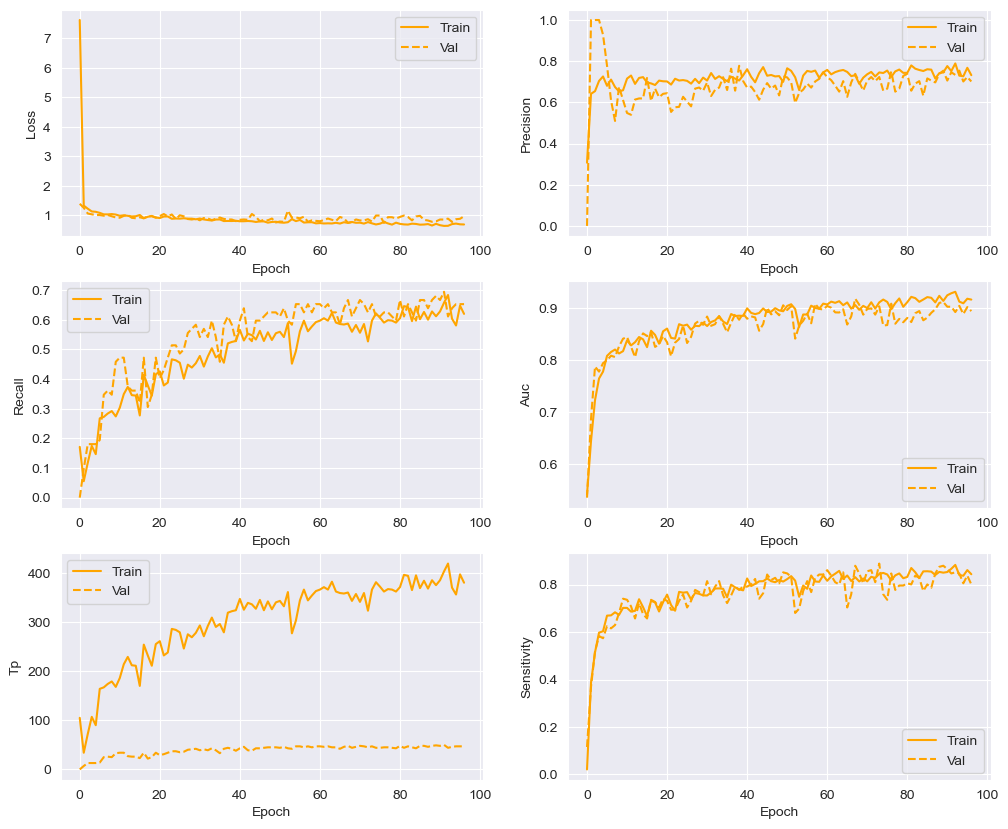

In [84]:
metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3, 2, n+1)
    plt.plot(history.epoch,  history.history[metric], color='orange', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
plt.show()